
# Project: European Soccer Database

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 

> The Soccer dataset consist of 7 different tables which are:
> <b><ol>1.Country</ol></b>
  <b><ol>2.League </ol></b>
<b><ol>3. Match </ol></b>
<b><ol>4. Player </ol></b>
<b><ol>5. Player attributes </ol></b>
<b><ol>6. Team </ol></b>
<b><ol>7. Team Attributes </ol></b>

>1. In the Country table, we have the Country ID and the Country Name. </br>
>2. In the League table, we have columns like Country_id and League_Name. </br>
>3. In the Match Table, we have several details of each Match played, the ones we'll be making use of in this Analysis are Season, Home_team_goal, Away_team_goal. 
>4. In the Player Table also consist of different columns,but the one's relevant for the purpose of this project are Player_api_id, height and weight. 
>5. We also have the Player Attributes tables, which cotains information about the attributes of the Players but for this project we'll be extracting the Player Attributes Column and The Player Potential Column. </br>
>6. The team table also consist of several columns and the one's we'll be extracting for this project work are Team_api_id, Team_Long_Name. 
>7. The team attributes tables also contains several details about the Team, but for this project, we're not extracting any details from the table.


### Question(s) for Analysis
>**1. Which Season was the highest number of goals scored, in which league?** 

>**2. Number of Recorded matches Per League** 

>**3. Who are the top 10 most rated Players?** 

>**4. Is there an Association between Player ratings and their Potentials?**

>**5. Is there an Association between Player weight and height?**

In [1]:
#import pandas
import pandas as pd
#import numpy
import numpy as np
#import matplotlib
import matplotlib as mpl
#import matplotlib.pyplot
import matplotlib.pyplot as plt
#Using matplotlib inline
%matplotlib inline
#import seaborn
import seaborn as sns
#Using ggplot style for graph
mpl.style.use(['ggplot'])
#import sqlite3
import sqlite3
#import stats
from scipy import stats

<a id='wrangling'></a>
## Data Wrangling

In this process, since we're having multiple tables for our data, we'll be using <b>sqlite</b> and <b> sql magic </b> to combine our data into two datasets, the first dataset will contain the <b>match details</b> in all seasons and Team details that'll be needing for this analysis, while the second dataset will contain the player details.

In [2]:
#Connecting to database with sqlite3
database = sqlite3.connect('database.sqlite')

In [3]:
#Connecting to database with SQL Magic
%load_ext sql
%sql sqlite:///database.sqlite

Here, We'll be creating <b>VIEWS</b> with <b>SQL MAGIC</b> to combine our data so we can have <b>match_data</b> dataset.
The column that'll be contained in the datasets are:
<code>Country_name,League_name,Season,Match_date,Home_team_name, Away_team_name,home_team_goal,away_team_goal,match_id,Total_goals</code>

In [4]:
%%sql
create view soccer_data
as
select C.name as Country_name,
L.name as League_name,
M.season as Season,
M.date as Match_date,
home_team.team_long_name as Home_team_name, 
away_team.team_long_name as Away_team_name,
M.Home_team_goal as home_team_goal,
M.away_team_goal as away_team_goal,
M.match_api_id as match_id
from Match M 
INNER JOIN 
Country as C ON
M.country_id = C.id
Inner join
League as L ON
M.league_id = L.id
left join
Team as home_team 
on
home_team.team_api_id = M.home_team_api_id
left join
Team as away_team
on
away_team.team_api_id = M.away_team_api_id;

 * sqlite:///database.sqlite
Done.


[]

**Printing the first 5 rows**

In [5]:
%%sql 
select * from soccer_data limit 5;

 * sqlite:///database.sqlite
Done.


Country_name,League_name,Season,Match_date,Home_team_name,Away_team_name,home_team_goal,away_team_goal,match_id
Belgium,Belgium Jupiler League,2008/2009,2008-08-17 00:00:00,KRC Genk,Beerschot AC,1,1,492473
Belgium,Belgium Jupiler League,2008/2009,2008-08-16 00:00:00,SV Zulte-Waregem,Sporting Lokeren,0,0,492474
Belgium,Belgium Jupiler League,2008/2009,2008-08-16 00:00:00,KSV Cercle Brugge,RSC Anderlecht,0,3,492475
Belgium,Belgium Jupiler League,2008/2009,2008-08-17 00:00:00,KAA Gent,RAEC Mons,5,0,492476
Belgium,Belgium Jupiler League,2008/2009,2008-08-16 00:00:00,FCV Dender EH,Standard de Liège,1,3,492477


Reading the View <code> soccer_data</code> into a DataFrame for further Inspection.

In [6]:
match_data = pd.read_sql_query("select * from soccer_data",database)

In [7]:
#Checking the size of our match_data
match_data.shape

(25979, 9)

From the result above, it shows that the dataset consist 25979 rows and 9 columns.

Now, we'll be creating generating our <code>player_data</code> also as this will be useful in order to answer some of our research question.
We'll  be Using <code>SQL MAGIC </code> as well to generate our data, and we'll be having columns:
<code>Player_api_id, Player_name, Player_average_weight,Player_average_height, Player_average_overall_rating, Player_average_potentials</code>

In [8]:
%%sql
create view player_data
as
select PA.player_api_id as Player_api_id,
P.player_name as Player_name,
P.weight as Player_average_weight,
P.height as Player_average_height,
round(avg(PA.overall_rating),2) as Player_average_overall_rating,
round(avg(PA.potential),2) as Player_average_potentials
from Player_attributes PA
left Join
Player P ON
PA.player_api_id = P.player_api_id
group by PA.player_api_id;

 * sqlite:///database.sqlite
Done.


[]

Reading view <code>player_data</code> into a dataframe for further Inspection.

In [9]:
player_data = pd.read_sql_query("select * from player_data",database)

In [10]:
#Checking the size of our player_data
player_data.shape

(11060, 6)

From the result above the dataset <code>player_data</code> consist of 11060 rows and 6 columns

In [11]:
#Printing the first 5 rows of the dataset
player_data.head(5)

,Player_api_id,Player_name,Player_average_weight,Player_average_height,Player_average_overall_rating,Player_average_potentials
0,2625,"Patryk Rachwal,18",154,175.26,60.14,61.14
1,2752,Diego Mainz,174,187.96,69.38,70.38
2,2768,Jose Dorado,154,180.34,69.29,70.57
3,2770,Ignacio Gonzalez,161,180.34,71.13,73.53
4,2790,Alberto Rey,163,175.26,70.20,75.80



### Data Cleaning

From the dataset <code>match_data</code> we noticed that we do not have a column where we'll have the total goal in a match, we only have <code>home_team_goal</code> and <code>away_team_goal</code>.
So let's create another Column and Name it <code>Total_goals</code> as this will be useful for us.

We'll be doing that in a few steps:
> **Step 1:** Using a for loop to add the columns **home_team_goal** and **away_team_goal**

In [12]:
Total_goals = [home_goal + away_goal for (home_goal,away_goal) in zip(match_data.home_team_goal,match_data.away_team_goal)]

> **Step 2:** Creating a column in the dataset <code>match_data</code> and naming the column <code>Total_goals</code>

In [13]:
match_data['Total_goals'] = Total_goals

In [14]:
#Lets Check for Changes
match_data.head(1)

,Country_name,League_name,Season,Match_date,Home_team_name,Away_team_name,home_team_goal,away_team_goal,match_id,Total_goals
0,Belgium,Belgium Jupiler League,2008/2009,2008-08-17 00:00:00,KRC Genk,Beerschot AC,1,1,492473,2


Now let's Check for missing data in dataset <code>match_data</code>

In [15]:
match_data.isnull().sum()

Country_name      0
League_name       0
Season            0
Match_date        0
Home_team_name    0
Away_team_name    0
home_team_goal    0
away_team_goal    0
match_id          0
Total_goals       0
dtype: int64

The result above shows that we have no missing data in any of the columns in the dataset <code>match_data</code>.
Next, let's Check for duplicates

In [16]:
match_data.duplicated().sum()

0

From the result above, it shows that we have no duplicated rows in the data <code>match_data</code>. Next, let's Check if our columns has the correct datatypes.

In [17]:
match_data.dtypes

Country_name      object
League_name       object
Season            object
Match_date        object
Home_team_name    object
Away_team_name    object
home_team_goal     int64
away_team_goal     int64
match_id           int64
Total_goals        int64
dtype: object

From the result above, the columns contains the correct datatypes.

**Next, Lets check for the data player_data also**

In [18]:
#Checking for Null values
player_data.isnull().sum()

Player_api_id                    0
Player_name                      0
Player_average_weight            0
Player_average_height            0
Player_average_overall_rating    0
Player_average_potentials        0
dtype: int64

From the result above, it shows that we have 0 null values in all the columns in the data <code> player_data</code>. Next, Let's check for duplicates.

In [19]:
#Checking for duplicated rows.
player_data.duplicated().sum()

0

From the result above we have 0 duplicated rows.Now, let's Check if our columns has the correct datatypes.

In [20]:
#checking for datatype.
player_data.dtypes

Player_api_id                      int64
Player_name                       object
Player_average_weight              int64
Player_average_height            float64
Player_average_overall_rating    float64
Player_average_potentials        float64
dtype: object

Looking at our <code>Player_average_weight</code> column we see that its datatype is **int** , so we need to change it to float since weight can be in float.

In [21]:
#changing column Player_average_weight to float.
player_data.Player_average_weight = player_data.Player_average_weight.astype('float')

In [22]:
#let's check for the changes.
player_data.Player_average_weight.dtype

dtype('float64')

**Since we've successfully clean our data, we can now go to the next step.**

<a id='eda'></a>
## Exploratory Data Analysis



### Research Question 1: Which Season was the highest number of goals scored, in which league?

Let's create our dataframe,by grouping our data <code>match_data</code> using <code>season</code>

In [23]:
season_goals = match_data.groupby('Season')['Total_goals'].sum()
season_goals

Season
2008/2009    8672
2009/2010    8632
2010/2011    8749
2011/2012    8747
2012/2013    9039
2013/2014    8389
2014/2015    8897
2015/2016    9162
Name: Total_goals, dtype: int64

The above result shows the number of goals scored in each season, we can explore this better by visualizing it.

**Let's define a function that will help to plot bar chart,so we can always reuse it in this project.**

In [24]:
#Creating Function for Barh Plot
def Barplot(data_name,plot_title,x_label,y_label):
    data_name.plot(kind = 'barh',figsize = (10,6))
    plt.title(plot_title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()
    

**Note: The Syntax for our Barplot function is Barplot(data_name,plot_title,x_label,y_label)**

Now, Let's Create a Barplot for <code>season_goals</code> data

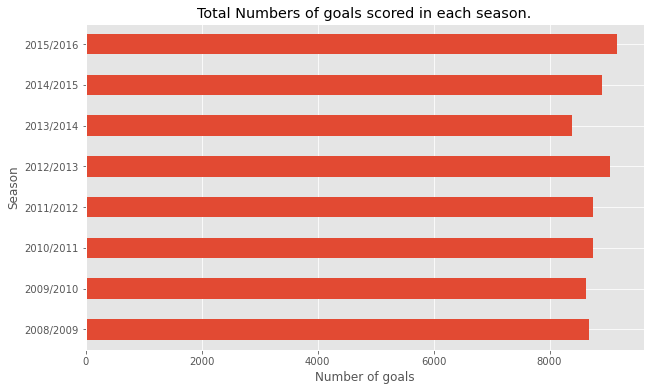

In [25]:
Barplot(season_goals,'Total Numbers of goals scored in each season.','Number of goals','Season')

**In which League, we need to further explore our data.**

Since we noticed clearly that the season where we have the highest number of goals scored is 2015/2016, we can use this to further explore our data to know which league was the highest number of goals scored.

In [26]:
#We use the query function to get the total_goals and League name of the season 2015/2016. 
league_goals = match_data.query('Season == "2015/2016"')[['League_name','Total_goals']]

Now we need to use the groupby function to get the league names and their corresponding goals for 2015/2016 season

In [27]:
league_goals.groupby('League_name').sum()

,Total_goals
League_name,
Belgium Jupiler League,694
England Premier League,1026
France Ligue 1,960
Germany 1. Bundesliga,866
Italy Serie A,979
Netherlands Eredivisie,912
Poland Ekstraklasa,635
Portugal Liga ZON Sagres,831
Scotland Premier League,650


In [28]:
#grouping our data by League_name and finding its sum
league_goals = league_goals.groupby('League_name').sum()

Let's explore with a plot for better understanding. </br>
We'll be using Barplot for Visualization here as well, and do not forget the syntax is: ``Barplot(data_name,plot_title,x_label,y_label)``

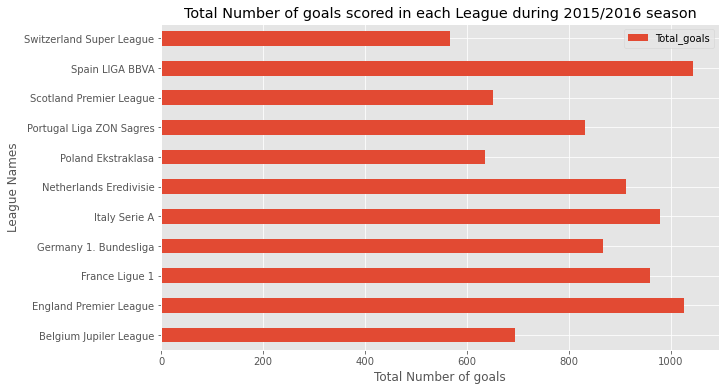

In [29]:
Barplot(league_goals,'Total Number of goals scored in each League during 2015/2016 season',
        'Total Number of goals','League Names')

From the result, above we the league with the highest number of goals in 2015/2016 season is **Spain LIGA BBVA**, We can use this info to proceed with our research question.

 ### Research Question 2:  Total number of Recorded matches Per League

Let's group our <code>Match_data</code> so that we can have the Count of all recorded games per league

In [30]:
matches_per_league = match_data.groupby('League_name').League_name.count()
matches_per_league

League_name
Belgium Jupiler League      1728
England Premier League      3040
France Ligue 1              3040
Germany 1. Bundesliga       2448
Italy Serie A               3017
Netherlands Eredivisie      2448
Poland Ekstraklasa          1920
Portugal Liga ZON Sagres    2052
Scotland Premier League     1824
Spain LIGA BBVA             3040
Switzerland Super League    1422
Name: League_name, dtype: int64

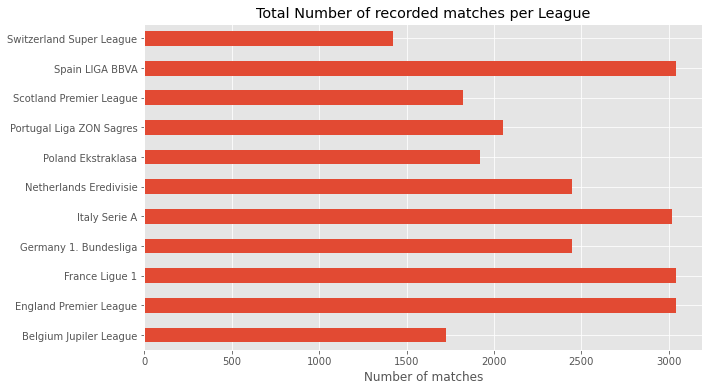

In [31]:
#Visualizing the data using our Barplot(function)
Barplot(matches_per_league,'Total Number of recorded matches per League','Number of matches','')

### Research Question 3:  Who are the top 10 most rated Players ?

We neeed to get the Top 10 Overall rated players of all time, to do this we have to sort our <code>player_data</code>

In [32]:
top_10= player_data.groupby('Player_name').Player_average_overall_rating.sum()

In [33]:
#Converting it into a dataframe.
top_10 = pd.DataFrame(top_10)

In [34]:
#Sorting the values so that we can get the top 10 rated players.
top10 = top_10.sort_values(['Player_average_overall_rating'],ascending = False).head(10)

In [35]:
#printing the result.
top10

,Player_average_overall_rating
Player_name,
Danilo,482.72
Paulinho,409.76
Ricardo,348.81
Fernando,301.38
Adriano,290.66
Felipe,290.40
Douglas,283.00
Roberto,280.39
Rafael,274.50


Let create a Barchart usin our ``Barplot()`` function.

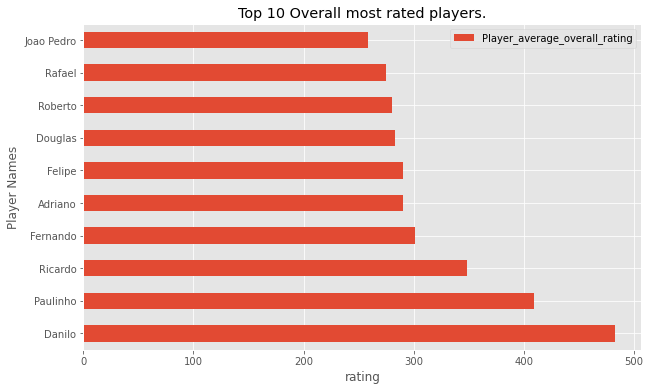

In [36]:
Barplot(top10,'Top 10 Overall most rated players.','rating','Player Names')

### Research Question 4: Is there any Association between Player ratings and their Potentials?

Let's Collect the both columns into another dataframe and then we'll visualize it with a scatter plot to see if there's an Association between them.

In [37]:
#Creating a new dataframe for Player ratings and Potentials
rating_and_potential = pd.concat([player_data.Player_average_overall_rating,player_data.Player_average_potentials],axis = 1)
rating_and_potential.head()

,Player_average_overall_rating,Player_average_potentials
0,60.14,61.14
1,69.38,70.38
2,69.29,70.57
3,71.13,73.53
4,70.20,75.80


Next, let's create a Scatter plot to see the relationships between rating and potential

Let's define our function for Scatter plot.

In [38]:
def Scatterplot(data_name,x_data,y_data,plot_title,x_label,y_label):
    data_name.plot(kind = 'scatter',x = x_data,y = y_data,figsize = (10,6))
    plt.title(plot_title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

**Note: The syntax for our function is:** ``Scatterplot(data_name,x_data,y_data,plot_title,x_label,y_label)`` </br>

Now, let's plot for ``rating_and_potential``


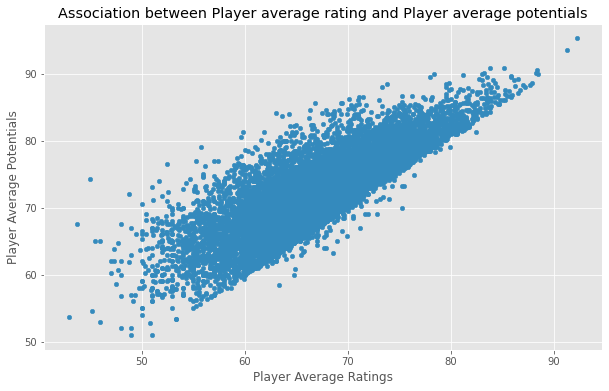

In [39]:
Scatterplot(rating_and_potential,'Player_average_overall_rating','Player_average_potentials',
           'Association between Player average rating and Player average potentials',"Player Average Ratings",
           "Player Average Potentials")

From the Result we have above, we can clearly see that we have a Strong Positive Correlation between Player's Average Rating and their Average Potentials.

Nevertheless, let's run some statistical test to support our claim.

In this case, we'll be Using **Pearson Correlation Coefficient** to know if there exist a linear relationship between Player average ratings and their Average Potentials and as well let's setup an hypothesis to know if <code>Player_average_rating</code> and <code>Player_average_potentials</code> are statistically Significant.

**H0: There is no significant relationship between Player Average rating and Player Average potentials.** </br>
**H1: There is significant relationship between Player Average rating and Player Average potentials.** </br>
Using 0.05 level of Significance


In [40]:
#Finding Pearson correlation coefficient and the p_value
pearson_coef,p_value = stats.pearsonr(player_data.Player_average_overall_rating,player_data.Player_average_potentials)
print(f'The Pearson Correlation coefficient is {pearson_coef}, and the pvalue is {p_value}')

The Pearson Correlation coefficient is 0.8094061670204304, and the pvalue is 0.0


From the result above, our Pearson Correlation coefficient is ~0.8 which shows that there is a strong positive correlation between the player's Average rating and their Average Potentials.

### Research Question 5: Is there an Association between Player weight and height?

Let's concat the columns <code>weight</code> and <code> height </code> into a dataframe

In [41]:
weight_and_height = pd.concat([player_data.Player_average_weight,player_data.Player_average_height],axis = 1)
#Print the first 5 rows.
weight_and_height.head()

,Player_average_weight,Player_average_height
0,154.0,175.26
1,174.0,187.96
2,154.0,180.34
3,161.0,180.34
4,163.0,175.26


We'll be Visualizing Using Scatter plot as well here and we'll be using our ``Scatterplot()`` function.

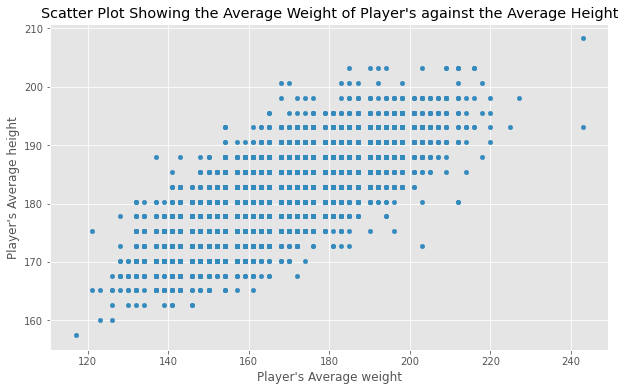

In [42]:
Scatterplot(weight_and_height,'Player_average_weight','Player_average_height',
            "Scatter Plot Showing the Average Weight of Player's against the Average Height",
            "Player's Average weight",
           "Player's Average height")

From the result above we can see that the trend follows a positive linear pattern which gives us insight that there's is an Association between them but we still need to further our analysis so that we can know the degree of Association between them.

We'll be using **Pearson Correlation Coefficient** to find our Correlation coefficent value and also run a Statistical hypothesis to back up our result.

Statistical hypothesis: </br>
**H0: There is no significant relationship between Player Average Weight and Average height.** </br>
**H1: There is significant relationship between Player Average Weight and Average height.** </br>
We'll be Using 0.05 Level of Significance.

In [43]:
#Let's find our Correlation Coefficient and pvalue
pearsonr2,p_value2 = stats.pearsonr(weight_and_height.Player_average_weight,weight_and_height.Player_average_height)
print(f'The Pearson correlation coefficient value is {pearsonr2} and the pvalue is {p_value2} ')

The Pearson correlation coefficient value is 0.7666258504097657 and the pvalue is 0.0 


Since the Pearson Correlation coefficient value is ~0.8, we therefore say that there is a strong positive correlation between Player Average Weight and Average Heigh.

<a id='conclusions'></a>
## Conclusions

### Research Question 1:
> From the analysis that we did in our reseach question 1, we find out that the most goals was scored during the 2015/2016 season of the European League, a total number of 9162 goals was scored, we also find out that it was during the Spain LIGA BBVA
league that the highest number  goal was scored in that Season, the numbers of goal scored was 1043.

### Research Question 2:
> According to the analysis we did in research question two, we were able to get the total number of matches that was played in each League from 2008/2009 season to 2015/2016 season, and from the anaysis the highest number of matches was played in English Premier League, France Ligue 1 and Spain LIGA BBVA with a number of 3040 matches each,followed by Italy Serie A league with 3017 number of matches,followed by Germany 1. Bundesliga and Netherlands Eredivisie League with a number of 2448 matches each, followed by Portugal Liga ZON Sagres with 2052 number of matches, followed by Poland Ekstraklasa league with 1920 number of matches, followed by Scotland Premier League with 1824 number of matches, followed by Belgium Jupiler League with 1728 number of matches,and then followed by Switzerland Super League  with 1422 number of matches.


### Research Question 3:


> According to the analysis for research question 3, we noticed that Danilo is most rated with 482.72 points, followed by Paulinho with 409.76 points, followed by Ricardo with 348.81 points, followed by Fernado with 301.38 points, followed by Adriano with 290.66 points, followed by Felipe with 290.40 points, followed by Douglas with 283 points, followed by Rafael with 274.50 points , then followed by Joao Pedro with 258.96 points.

### Research Question 4:

> According to the correlation we carried in research question 4, we got Pearson Correlation Coefficient value of ~0.8, this simply implies that there is a strong Positive Linear Correlation between Player Overall average rating and their Potentials.
> Also we carried out a Statistical Test to comfirm if they're statistically Significant, with a 0.05 level of Significance, and from our result we got a pvalue of 0.00, these shows that our pvalue is very small, and decision rule states that we're to reject the null hypothesis if the pvalue < level of siginicance(0.05 in this case), Since our pvalue(0.00) is less than 0.05, we therefore reject the null hypothesis and Conclude that the correlation between <code>Player Overall average rating</code> and <code> Player Average Potential </code> are Statistically Significant, and thus there is a Significant relationship between them.

### Research Question 5:
> According to the Pearson Correlation coefficient value that we got which is ~0.8 , it implies that there is a Strong Positive Linear Association between Player Average Weight and Player Average Height.
> We need to Statistically prove this as well, so we carried out a Statistical test with 0.05 level of Significance, and from the resul obtained, our pvalue is 0.00, and since the decision rule states that we are to reject the Null hypothesis if the pvalue is less than the Level of Significance, thus we obtained pvalue of 0.00, and 0.00 < 0.05, we therefore reject the null hypothesis and conclude that the correlation coefficient value (0.766) is statistically significant,and the linear relationship is extremely strong, therefore there is Statistical Relationship between Player Average Weight and Player Average height.

### Limitations.
>1.  Dealing with several data for one analysis can be so complicated, it really took me alot of time to get through with understanding the Tables and how they're linked together. </br>
>2.  There are still alot of analysis that can still be done with the tables,however i had issues with some of the columns in ``Match`` data, columns like ``foulcommit`` , ``cross``, ``corner``,``possession`` etc., the columns seems to contain some values which i think will be difficult to clean.

